<a href="https://colab.research.google.com/github/vaishnavieduvarikuti-cpu/Brain-Tumor-ViT-Comparison/blob/main/brain%20tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
files.upload() # Upload your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srivaishu006","key":"7311f42817946c93df6805e0546f2c3a"}'}

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 1.42GB/s]
100% 149M/149M [00:00<00:00, 1.40GB/s]


In [8]:
# ===================================================================
# FINAL CORRECTED ALL-IN-ONE CODE BLOCK
# ===================================================================

# --- CELL 1: IMPORTS ---
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

print("--- Step 1: Libraries Imported ---")

# --- CELL 2: CONFIGURATION ---
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/'
IMAGE_SIZE = 224
BATCH_SIZE = 8 # <<< FINAL CHANGE TO FIX MEMORY ERROR
EPOCHS = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Configuration Set (Using device: {device}, Batch Size: {BATCH_SIZE}) ---")

# --- CELL 3: DATA LOADING ---
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

train_val_df, label_map = load_data(DATA_DIR)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])
print("--- Step 3: Data Loaded and Split ---")

# --- CELL 4: PREPROCESSING & DATASETS ---
IMAGENET_MEAN = [0.485, 0.456, 0.46]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
train_dataset = TumorDataset(train_df, transform=train_transform)
val_dataset = TumorDataset(val_df, transform=val_test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("--- Step 4: DataLoaders Ready ---")

# --- CELL 5: TRAINING FUNCTION ---
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'/content/{model_name}_best.pth')
            print(f"----> New best model saved")
    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy
print("--- Step 5: Training Function Defined ---")

# --- FINAL STEP: TRAIN THE TINY MAXVIT MODEL ---
print("\n--- Starting Final Step: Training the Tiny MaxViT Model ---")
maxvit_model_name = 'maxvit_tiny_tf_224'
maxvit_model = timm.create_model(maxvit_model_name, pretrained=True, num_classes=len(label_map))
maxvit_model.to(device)
maxvit_accuracy = train_model(maxvit_model, maxvit_model_name, train_loader, val_loader, EPOCHS, 1e-5)
print(f"\nBest Validation Accuracy for Tiny MaxViT: {maxvit_accuracy:.4f}")

--- Step 1: Libraries Imported ---
--- Step 2: Configuration Set (Using device: cuda, Batch Size: 8) ---
--- Step 3: Data Loaded and Split ---
--- Step 4: DataLoaders Ready ---
--- Step 5: Training Function Defined ---

--- Starting Final Step: Training the Tiny MaxViT Model ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]


Epoch 1/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.61it/s]


Validation Accuracy: 0.8941
----> New best model saved

Epoch 2/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 15.97it/s]


Validation Accuracy: 0.9414
----> New best model saved

Epoch 3/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.87it/s]


Validation Accuracy: 0.9641
----> New best model saved

Epoch 4/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.69it/s]


Validation Accuracy: 0.9685
----> New best model saved

Epoch 5/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.04it/s]


Validation Accuracy: 0.9764
----> New best model saved

Epoch 6/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.84it/s]


Validation Accuracy: 0.9816
----> New best model saved

Epoch 7/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.76it/s]


Validation Accuracy: 0.9816

Epoch 8/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.70it/s]


Validation Accuracy: 0.9869
----> New best model saved

Epoch 9/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.04it/s]


Validation Accuracy: 0.9843

Epoch 10/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.63it/s]


Validation Accuracy: 0.9834

Epoch 11/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.53it/s]


Validation Accuracy: 0.9843

Epoch 12/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.57it/s]


Validation Accuracy: 0.9860

Epoch 13/20


Validation: 100%|██████████| 143/143 [00:10<00:00, 13.30it/s]


Validation Accuracy: 0.9878
----> New best model saved

Epoch 14/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.41it/s]


Validation Accuracy: 0.9860

Epoch 15/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.53it/s]


Validation Accuracy: 0.9895
----> New best model saved

Epoch 16/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.55it/s]


Validation Accuracy: 0.9851

Epoch 17/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.82it/s]


Validation Accuracy: 0.9886

Epoch 18/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.25it/s]


Validation Accuracy: 0.9913
----> New best model saved

Epoch 19/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.53it/s]


Validation Accuracy: 0.9895

Epoch 20/20


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.82it/s]


Validation Accuracy: 0.9860

Finished Training for maxvit_tiny_tf_224!

Best Validation Accuracy for Tiny MaxViT: 0.9913


In [9]:
# --- FINAL STEP: TRAIN THE TINY SWIN TRANSFORMER ---
print("\n--- Starting Final Step: Training the Tiny Swin Transformer ---")
# NOTE: We are using the 'tiny' Swin model for a fair comparison and to avoid memory errors
swin_model_name = 'swin_tiny_patch4_window7_224'

swin_model = timm.create_model(swin_model_name, pretrained=True, num_classes=len(label_map))
swin_model.to(device)

swin_accuracy = train_model(
    model=swin_model,
    model_name=swin_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

print(f"\nBest Validation Accuracy for Tiny Swin Transformer: {swin_accuracy:.4f}")


--- Starting Final Step: Training the Tiny Swin Transformer ---


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Epoch 1/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 19.88it/s]


Validation Accuracy: 0.9493
----> New best model saved

Epoch 2/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.36it/s]


Validation Accuracy: 0.9738
----> New best model saved

Epoch 3/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.11it/s]


Validation Accuracy: 0.9825
----> New best model saved

Epoch 4/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.31it/s]


Validation Accuracy: 0.9869
----> New best model saved

Epoch 5/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 19.67it/s]


Validation Accuracy: 0.9790

Epoch 6/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.09it/s]


Validation Accuracy: 0.9921
----> New best model saved

Epoch 7/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.13it/s]


Validation Accuracy: 0.9930
----> New best model saved

Epoch 8/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 22.50it/s]


Validation Accuracy: 0.9790

Epoch 9/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.10it/s]


Validation Accuracy: 0.9878

Epoch 10/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 21.53it/s]


Validation Accuracy: 0.9948
----> New best model saved

Epoch 11/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.00it/s]


Validation Accuracy: 0.9825

Epoch 12/20


Validation: 100%|██████████| 143/143 [00:08<00:00, 17.28it/s]


Validation Accuracy: 0.9930

Epoch 13/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.28it/s]


Validation Accuracy: 0.9939

Epoch 14/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 19.78it/s]


Validation Accuracy: 0.9895

Epoch 15/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.14it/s]


Validation Accuracy: 0.9948

Epoch 16/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 19.92it/s]


Validation Accuracy: 0.9913

Epoch 17/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.00it/s]


Validation Accuracy: 0.9913

Epoch 18/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 20.03it/s]


Validation Accuracy: 0.9913

Epoch 19/20


Validation: 100%|██████████| 143/143 [00:06<00:00, 23.22it/s]


Validation Accuracy: 0.9895

Epoch 20/20


Validation: 100%|██████████| 143/143 [00:07<00:00, 19.98it/s]

Validation Accuracy: 0.9895

Finished Training for swin_tiny_patch4_window7_224!

Best Validation Accuracy for Tiny Swin Transformer: 0.9948


In [ ]:
from google.colab import files
print("Please upload your kaggle.json API token.")
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

In [10]:
# Imports
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Configuration
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/'
IMAGE_SIZE = 224
BATCH_SIZE = 8 # Use the same batch size as your final successful training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Libraries imported and configuration set. Using device: {device}")

Libraries imported and configuration set. Using device: cuda


In [11]:
# Data Loading Function
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

# Load dataframes
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Define Transformation
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the Test DataLoader
test_dataset = TumorDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Test data is loaded and ready for evaluation.")

Test data is loaded and ready for evaluation.


In [12]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

--- Running Final Evaluation for Srivaishnavi's Project ---

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 164/164 [00:07<00:00, 20.54it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9908466819221968

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



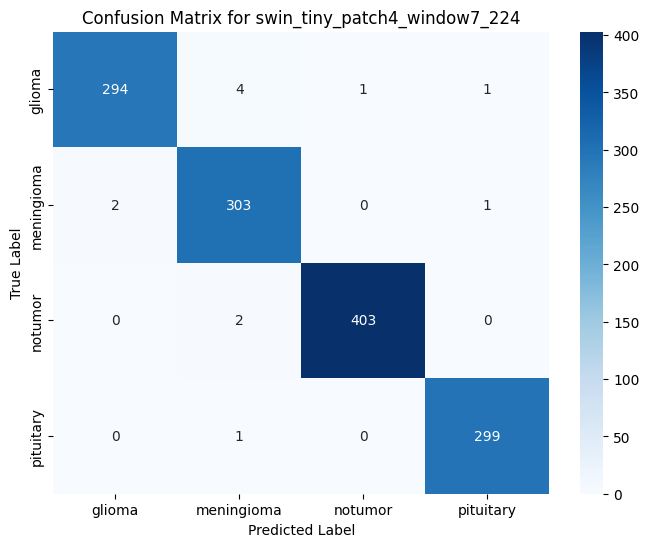


   Starting Evaluation for: maxvit_tiny_tf_224


Evaluating maxvit_tiny_tf_224: 100%|██████████| 164/164 [00:10<00:00, 15.19it/s]



--- Evaluation Report for maxvit_tiny_tf_224 ---
Accuracy: 0.9832189168573608

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       300
  meningioma       0.99      0.96      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



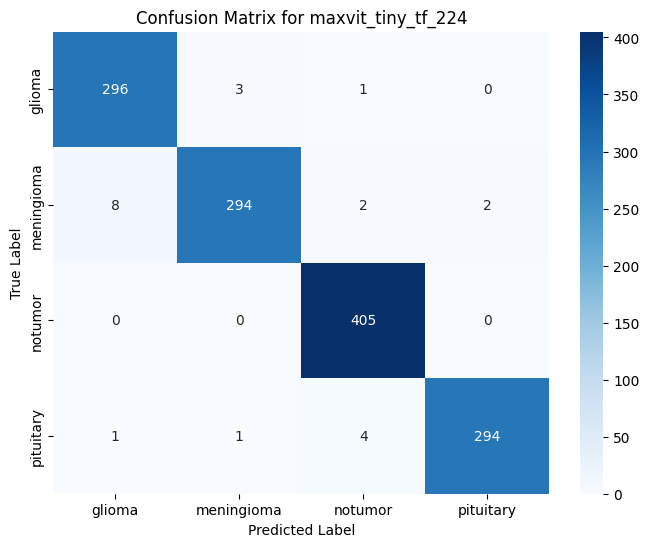

In [13]:
# --- This is the code for YOUR project (Swin + MaxViT) ---
print("--- Running Final Evaluation for Srivaishnavi's Project ---")

# Define the EXACT model names YOU trained
swin_model_name = 'swin_tiny_patch4_window7_224'
maxvit_model_name = 'maxvit_tiny_tf_224'

# Call the function for each of your models
# IMPORTANT: Make sure the files 'swin_tiny..._best.pth' and 'maxvit_tiny..._best.pth' are in your /content/ directory.
# If they are not there, you must re-run the training for them first.
evaluate_model(swin_model_name, test_loader, label_map)
evaluate_model(maxvit_model_name, test_loader, label_map)

In [ ]:
from google.colab import files
files.upload() # Upload your kaggle.json

In [ ]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip

In [ ]:
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add this line for confirmation
print(f"Libraries imported successfully. Using device: {device}")

In [14]:
# ===================================================================
# ALL-IN-ONE CODE BLOCK FOR EXPERIMENT 1
# ===================================================================

# --- STEP 1: IMPORTS ---
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
print("--- Step 1: Libraries Imported ---")

# --- STEP 2: CONFIGURATION ---
DATA_DIR = '/content/dataset/Training/'
IMAGE_SIZE = 224
BATCH_SIZE = 8      # Using the safe batch size
EPOCHS = 35         # <<< EXPERIMENT 1: Training for 35 epochs
LEARNING_RATE = 1e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- Step 2: Configuration Set (Device: {device}, Epochs: {EPOCHS}) ---")

# --- STEP 3: DATA LOADING ---
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

train_val_df, label_map = load_data(DATA_DIR)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label'])
print("--- Step 3: Data Loaded and Split ---")
print(f"Label map: {label_map}")
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# --- STEP 4: PREPROCESSING & DATASETS ---
IMAGENET_MEAN, IMAGENET_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
class TumorDataset(Dataset):
    def __init__(self, df, transform=None): self.df, self.transform = df, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
train_dataset, val_dataset = TumorDataset(train_df, transform=train_transform), TumorDataset(val_df, transform=val_test_transform)
train_loader, val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2), DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("--- Step 4: DataLoaders Ready ---")

# --- STEP 5: TRAINING FUNCTION ---
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'/content/{model_name}_best.pth')
            print(f"----> New best model saved")
    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy
print("--- Step 5: Training Function Defined ---")

# --- FINAL STEP: TRAIN THE TINY MAXVIT MODEL ---
print("\n--- Starting Final Step: Training the Tiny MaxViT Model ---")
maxvit_model_name = 'maxvit_tiny_tf_224'
maxvit_model = timm.create_model(maxvit_model_name, pretrained=True, num_classes=len(label_map))
maxvit_model.to(device)
maxvit_accuracy = train_model(maxvit_model, maxvit_model_name, train_loader, val_loader, EPOCHS, LEARNING_RATE)
print(f"\nBest Validation Accuracy for Tiny MaxViT (Experiment 1): {maxvit_accuracy:.4f}")

--- Step 1: Libraries Imported ---
--- Step 2: Configuration Set (Device: cuda, Epochs: 35) ---
--- Step 3: Data Loaded and Split ---
Label map: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training samples: 4569, Validation samples: 1143
--- Step 4: DataLoaders Ready ---
--- Step 5: Training Function Defined ---

--- Starting Final Step: Training the Tiny MaxViT Model ---

Epoch 1/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.64it/s]


Validation Accuracy: 0.8906
----> New best model saved

Epoch 2/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.76it/s]


Validation Accuracy: 0.9475
----> New best model saved

Epoch 3/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.70it/s]


Validation Accuracy: 0.9633
----> New best model saved

Epoch 4/35


Validation: 100%|██████████| 143/143 [00:08<00:00, 16.03it/s]


Validation Accuracy: 0.9729
----> New best model saved

Epoch 5/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.63it/s]


Validation Accuracy: 0.9729

Epoch 6/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.81it/s]


Validation Accuracy: 0.9799
----> New best model saved

Epoch 7/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.35it/s]


Validation Accuracy: 0.9834
----> New best model saved

Epoch 8/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.67it/s]


Validation Accuracy: 0.9869
----> New best model saved

Epoch 9/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.72it/s]


Validation Accuracy: 0.9781

Epoch 10/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.37it/s]


Validation Accuracy: 0.9860

Epoch 11/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.67it/s]


Validation Accuracy: 0.9860

Epoch 12/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.76it/s]


Validation Accuracy: 0.9878
----> New best model saved

Epoch 13/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.89it/s]


Validation Accuracy: 0.9895
----> New best model saved

Epoch 14/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.78it/s]


Validation Accuracy: 0.9878

Epoch 15/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.74it/s]


Validation Accuracy: 0.9878

Epoch 16/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.32it/s]


Validation Accuracy: 0.9895

Epoch 17/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.36it/s]


Validation Accuracy: 0.9825

Epoch 18/35


Validation: 100%|██████████| 143/143 [00:10<00:00, 13.41it/s]


Validation Accuracy: 0.9895

Epoch 19/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.82it/s]


Validation Accuracy: 0.9860

Epoch 20/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.88it/s]


Validation Accuracy: 0.9895

Epoch 21/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.75it/s]


Validation Accuracy: 0.9895

Epoch 22/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.55it/s]


Validation Accuracy: 0.9860

Epoch 23/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.72it/s]


Validation Accuracy: 0.9869

Epoch 24/35


Validation: 100%|██████████| 143/143 [00:08<00:00, 15.97it/s]


Validation Accuracy: 0.9729

Epoch 25/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.97it/s]


Validation Accuracy: 0.9913
----> New best model saved

Epoch 26/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.72it/s]


Validation Accuracy: 0.9886

Epoch 27/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.73it/s]


Validation Accuracy: 0.9843

Epoch 28/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.63it/s]


Validation Accuracy: 0.9869

Epoch 29/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.68it/s]


Validation Accuracy: 0.9878

Epoch 30/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.78it/s]


Validation Accuracy: 0.9895

Epoch 31/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.64it/s]


Validation Accuracy: 0.9904

Epoch 32/35


Validation: 100%|██████████| 143/143 [00:10<00:00, 13.88it/s]


Validation Accuracy: 0.9790

Epoch 33/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 14.90it/s]


Validation Accuracy: 0.9895

Epoch 34/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.23it/s]


Validation Accuracy: 0.9913

Epoch 35/35


Validation: 100%|██████████| 143/143 [00:09<00:00, 15.73it/s]

Validation Accuracy: 0.9904

Finished Training for maxvit_tiny_tf_224!

Best Validation Accuracy for Tiny MaxViT (Experiment 1): 0.9913


--- Running Final Evaluation for Srivaishnavi's Project ---

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 164/164 [00:09<00:00, 18.13it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9908466819221968

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



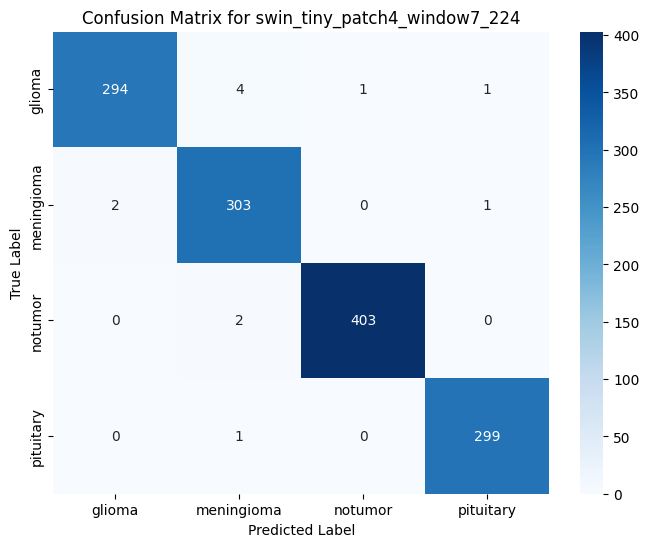


   Starting Evaluation for: maxvit_tiny_tf_224


Evaluating maxvit_tiny_tf_224: 100%|██████████| 164/164 [00:11<00:00, 14.67it/s]



--- Evaluation Report for maxvit_tiny_tf_224 ---
Accuracy: 0.9916094584286804

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



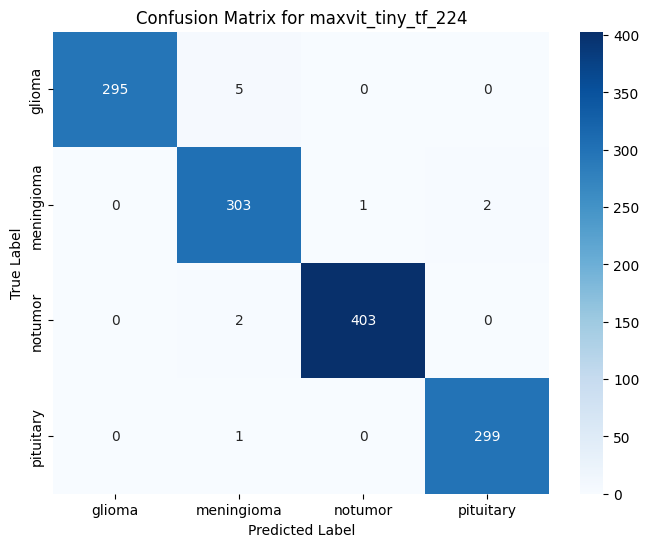

In [15]:
# --- This is the code for YOUR project (Swin + MaxViT) ---
print("--- Running Final Evaluation for Srivaishnavi's Project ---")

# Define the EXACT model names YOU trained
swin_model_name = 'swin_tiny_patch4_window7_224'
maxvit_model_name = 'maxvit_tiny_tf_224'

# Call the function for each of your models
# IMPORTANT: Make sure the files 'swin_tiny..._best.pth' and 'maxvit_tiny..._best.pth' are in your /content/ directory.
# If they are not there, you must re-run the training for them first.
evaluate_model(swin_model_name, test_loader, label_map)
evaluate_model(maxvit_model_name, test_loader, label_map)

In [16]:
print("--- Starting Phase 2: Simple Fusion (Averaging) ---")

# --- Load All Your Trained Models ---
# IMPORTANT: Make sure the .pth files are in your /content/ directory.
# If they are not, you must run the training for them again, or upload them manually.
model_names = [
    'swin_tiny_patch4_window7_224',
    'maxvit_tiny_tf_224'
    # Add 'deit_tiny_patch16_224' if you and your friend are combining results
]

models = []
for name in model_names:
    model = timm.create_model(name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        model.eval()
        models.append(model)
        print(f"Successfully loaded {name}")
    except FileNotFoundError:
        print(f"ERROR: Could not find {model_path}. Please train this model first.")

# --- Run Fusion Evaluation ---
if len(models) == len(model_names):
    all_fused_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Running Fusion Evaluation"):
            images = images.to(device)
            all_labels.extend(labels.cpu().numpy())

            all_probs = []
            for model in models:
                outputs = model(images)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                all_probs.append(probs)

            stacked_probs = torch.stack(all_probs)
            mean_probs = torch.mean(stacked_probs, dim=0)
            _, fused_preds = torch.max(mean_probs, 1)
            all_fused_preds.extend(fused_preds.cpu().numpy())

    # --- Print Evaluation Metrics for the Fused Model ---
    print("\n======================================================")
    print("   Evaluation Report for Fused (Ensemble) Model")
    print("======================================================")
    class_names = list(label_map.keys())
    print("Accuracy:", accuracy_score(all_labels, all_fused_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_fused_preds, target_names=class_names))

--- Starting Phase 2: Simple Fusion (Averaging) ---
Successfully loaded swin_tiny_patch4_window7_224
Successfully loaded maxvit_tiny_tf_224


Running Fusion Evaluation: 100%|██████████| 164/164 [00:16<00:00,  9.84it/s]


   Evaluation Report for Fused (Ensemble) Model
Accuracy: 0.9938977879481312

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [17]:
print("--- Starting Phase 3: Advanced Fusion (MLP) ---")
print("--- Step 3.2: Extracting Features ---")

# Load your trained models
model_names = ['swin_tiny_patch4_window7_224', 'maxvit_tiny_tf_224']
models = []
for name in model_names:
    model = timm.create_model(name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{name}_best.pth'
    model.load_state_dict(torch.load(model_path))
    # Remove the final classification layer to get the features
    model.reset_classifier(0)
    model.to(device)
    model.eval()
    models.append(model)

# Function to extract features
def extract_features(loader, models):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting features"):
            images = images.to(device)

            # Get features from each model and concatenate them
            batch_features = [model(images) for model in models]
            concatenated_features = torch.cat(batch_features, dim=1)

            all_features.append(concatenated_features.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_features), torch.cat(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_features(train_loader, models)
val_features, val_labels = extract_features(val_loader, models)
test_features, test_labels = extract_features(test_loader, models)

print(f"\nFeature extraction complete. Shape of training features: {train_features.shape}")

--- Starting Phase 3: Advanced Fusion (MLP) ---
--- Step 3.2: Extracting Features ---


Extracting features: 100%|██████████| 164/164 [00:16<00:00, 10.14it/s]


Feature extraction complete. Shape of training features: torch.Size([4569, 1280])


In [18]:
print("--- Step 3.3: Creating MLP DataLoaders ---")

# A simple Dataset for our features
class MLPDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create new datasets and dataloaders
mlp_train_dataset = MLPDataset(train_features, train_labels)
mlp_val_dataset = MLPDataset(val_features, val_labels)
mlp_test_dataset = MLPDataset(test_features, test_labels)

mlp_train_loader = DataLoader(mlp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = DataLoader(mlp_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
mlp_test_loader = DataLoader(mlp_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("MLP DataLoaders are ready.")

--- Step 3.3: Creating MLP DataLoaders ---
MLP DataLoaders are ready.


In [19]:
print("--- Step 3.4: Defining and Training the MLP ---")

# Define a simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Initialize and train the MLP
input_size = train_features.shape[1]
mlp_model = MLP(input_size, num_classes=len(label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Simple training loop for the MLP
for epoch in range(25): # MLPs train very fast
    mlp_model.train()
    for features, labels in mlp_train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"MLP Epoch {epoch+1}/25, Loss: {loss.item():.4f}")

print("\nMLP training complete.")

# --- Step 3.5: Evaluate the MLP ---
mlp_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features, labels in mlp_test_loader:
        features = features.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n======================================================")
print("   Evaluation Report for MLP Fusion Model")
print("======================================================")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))

--- Step 3.4: Defining and Training the MLP ---
MLP Epoch 1/25, Loss: 0.0000
MLP Epoch 2/25, Loss: 0.0000
MLP Epoch 3/25, Loss: 0.0000
MLP Epoch 4/25, Loss: 0.0000
MLP Epoch 5/25, Loss: 0.0000
MLP Epoch 6/25, Loss: 0.0000
MLP Epoch 7/25, Loss: 0.0000
MLP Epoch 8/25, Loss: 0.0000
MLP Epoch 9/25, Loss: 0.0000
MLP Epoch 10/25, Loss: 0.0000
MLP Epoch 11/25, Loss: 0.0000
MLP Epoch 12/25, Loss: 0.0000
MLP Epoch 13/25, Loss: 0.0000
MLP Epoch 14/25, Loss: 0.0000
MLP Epoch 15/25, Loss: 0.0000
MLP Epoch 16/25, Loss: 0.0000
MLP Epoch 17/25, Loss: 0.0000
MLP Epoch 18/25, Loss: 0.0000
MLP Epoch 19/25, Loss: 0.0000
MLP Epoch 20/25, Loss: 0.0000
MLP Epoch 21/25, Loss: 0.0000
MLP Epoch 22/25, Loss: 0.0000
MLP Epoch 23/25, Loss: 0.0000
MLP Epoch 24/25, Loss: 0.0000
MLP Epoch 25/25, Loss: 0.0000

MLP training complete.

   Evaluation Report for MLP Fusion Model
Accuracy: 0.9946605644546148

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98   

In [21]:
!pip install grad-cam ttach

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=9a1c1f3251376898876ddf302c9918f8eff7cdccbc6b6d602aa87d5fa0d73a5a
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [22]:
print("--- Starting Phase 4: Explainable AI (XAI) ---")
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np # Make sure numpy is imported

# --- Load your best trained model (e.g., Swin Transformer) ---
model_name = 'swin_tiny_patch4_window7_224'
model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
model_path = f'/content/{model_name}_best.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# --- Define the target layer for visualization ---
target_layers = [model.layers[-1].blocks[-1].norm2]

# --- Get a few sample images from the test set ---
sample_images, sample_labels = next(iter(test_loader))
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
class_names = list(label_map.keys())

# --- Generate and display heatmaps ---
cam = GradCAM(model=model, target_layers=target_layers)

for i in range(5): # Visualize 5 images
    input_tensor = sample_images[i].unsqueeze(0)
    # Convert to a float32 numpy array for visualization
    rgb_img = inv_normalize(sample_images[i]).permute(1, 2, 0).cpu().numpy().astype(np.float32)

    targets = [ClassifierOutputTarget(sample_labels[i].item())]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original Image\nTrue Label: {class_names[sample_labels[i].item()]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

--- Starting Phase 4: Explainable AI (XAI) ---


ValueError: Invalid grads shape.Shape of grads should be 4 (2D image) or 5 (3D image).

--- Starting Phase 4: Explainable AI (XAI) ---


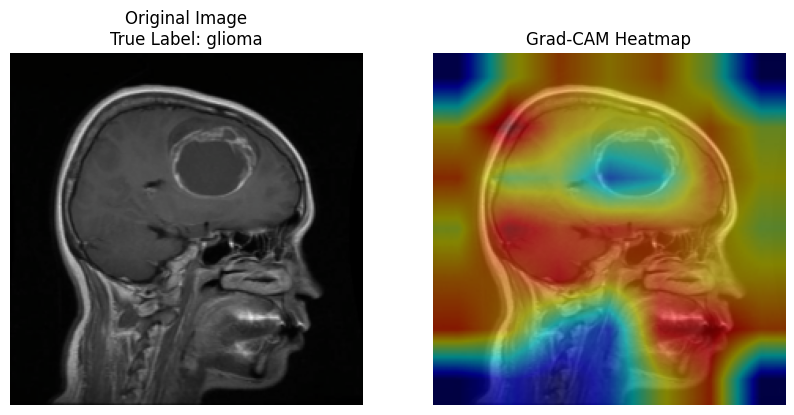

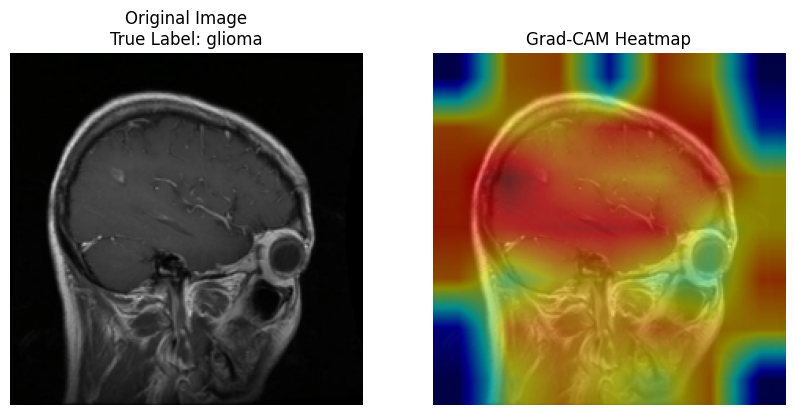

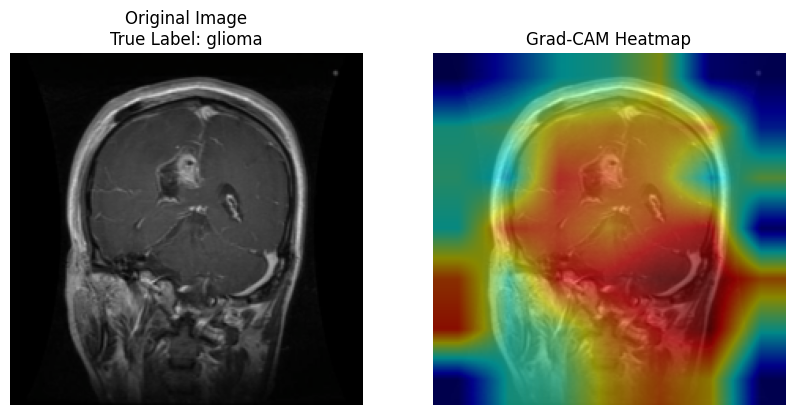

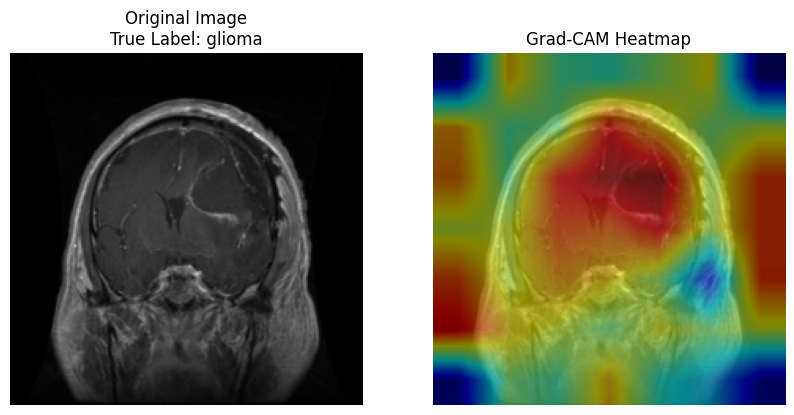

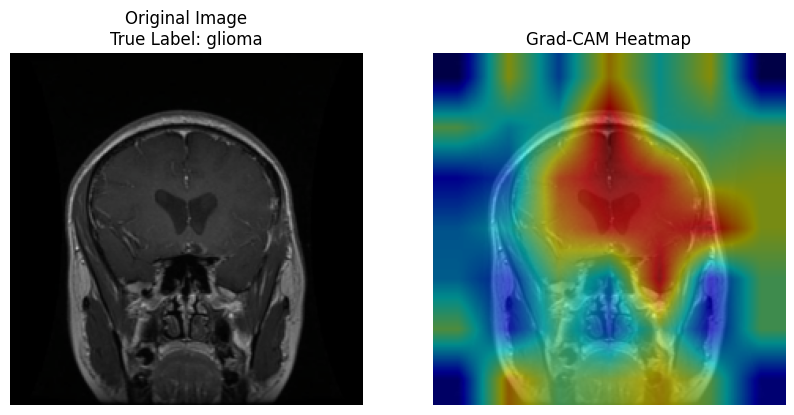

In [23]:
# ===================================================================
# CORRECTED ALL-IN-ONE CODE FOR PHASE 4 (XAI)
# ===================================================================

print("--- Starting Phase 4: Explainable AI (XAI) ---")
# Make sure the library is installed
!pip install grad-cam ttach -q

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

# --- Load your best trained model (e.g., Swin Transformer) ---
model_name = 'swin_tiny_patch4_window7_224'
model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
model_path = f'/content/{model_name}_best.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# --- Define the target layer for visualization ---
target_layers = [model.layers[-1].blocks[-1].norm2]


# --- NEW: Define the reshape_transform function for Swin Transformer ---
# This function correctly reshapes the transformer's output for Grad-CAM
def reshape_transform(tensor, height=7, width=7):
    # The output of the Swin Transformer's last layer is not a 2D grid.
    # This function reshapes it to (batch_size, height, width, channels)
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring channels to the second dimension (batch_size, channels, height, width)
    result = result.permute(0, 3, 1, 2)
    return result


# --- Get a few sample images from the test set ---
sample_images, sample_labels = next(iter(test_loader))
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
class_names = list(label_map.keys())

# --- Generate and display heatmaps ---
# --- MODIFIED: Pass the reshape_transform to GradCAM ---
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

for i in range(5): # Visualize 5 images
    input_tensor = sample_images[i].unsqueeze(0)
    # Convert to a float32 numpy array for visualization
    rgb_img = inv_normalize(sample_images[i]).permute(1, 2, 0).cpu().numpy().astype(np.float32)

    targets = [ClassifierOutputTarget(sample_labels[i].item())]
    # The line below should now work correctly
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original Image\nTrue Label: {class_names[sample_labels[i].item()]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()